<a href="https://colab.research.google.com/github/radiadus/Emotion-Classification-Using-LSTM-Information-Retrieval/blob/main/Emotion_Classification_LSTM_Information_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries yang diperlukan (Pandas, Numpy, Re, NLTK, Tensorflow, Keras, Sklearn)

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

Melakukan read file CSV yang berisi 21.459 Data dan terdiri dari 6 labels

In [ ]:
df = pd.read_csv('Emotion_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [ ]:
df.Emotion.value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

Memisahkan Data berdasarkan label emosi dan menaruhnya pada variabel baru. Kemudian dilakukan resample untuk setiap jenis data kecuali label happy agar jumlah data untuk setiap label menjadi sama seperti jumlah data pada label happy (7.029 data).

In [ ]:
happy = df.loc[df.Emotion == "happy"]
sadness = df.loc[df.Emotion == "sadness"]
anger = df.loc[df.Emotion == "anger"]
fear = df.loc[df.Emotion == "fear"]
love = df.loc[df.Emotion == "love"]
surprise = df.loc[df.Emotion == "surprise"]

In [ ]:
sadness = resample(sadness, replace=True, n_samples=len(happy), random_state=42)
anger = resample(anger, replace=True, n_samples=len(happy), random_state=42)
fear = resample(fear, replace=True, n_samples=len(happy), random_state=42)
love = resample(love, replace=True, n_samples=len(happy), random_state=42)
surprise = resample(surprise, replace=True, n_samples=len(happy), random_state=42)

In [ ]:
anger

,Text,Emotion
6414,i surmise that after i have made myself sick o...,anger
9617,i still feel so irritable every day,anger
8318,im exhausted in excruciating pain and feeling ...,anger
8037,i will try not to feel rushed along with other...,anger
12163,i keep waiting for some grand stroke of wisdom...,anger
...,...,...
2379,i ate feeling hateful towards myself because o...,anger
4584,i know that i still feel kind of agitated but ...,anger
19985,i started to see a concerning pattern i d rush...,anger
4,i am feeling grouchy,anger


Setelah itu semua data digabungkan kembali menjadi satu dan ditaruh pada variabel df.

In [ ]:
df = pd.concat([happy, sadness, anger, fear, love, surprise])
df

,Text,Emotion
8,i have been with petronas for years i feel tha...,happy
11,i do feel that running is a divine experience ...,happy
14,i have immense sympathy with the general point...,happy
15,i do not feel reassured anxiety is on each side,happy
22,i have the feeling she was amused and delighted,happy
...,...,...
3702,i look back on that i feel amazed that at such...,surprise
7818,i feel so amazed seeing chiangmai,surprise
19817,i feel dazed and empty and like somthing is mi...,surprise
15470,i feel funny just calling it a film,surprise


Saat ini seluruh label emosi sudah memiliki jumlah data yang sama.

In [ ]:
df.Emotion.value_counts()

fear        7029
sadness     7029
happy       7029
love        7029
surprise    7029
anger       7029
Name: Emotion, dtype: int64

Memisahkan features dan target dari dataset

In [ ]:
features = df.Text
features

8        i have been with petronas for years i feel tha...
11       i do feel that running is a divine experience ...
14       i have immense sympathy with the general point...
15         i do not feel reassured anxiety is on each side
22         i have the feeling she was amused and delighted
                               ...                        
3702     i look back on that i feel amazed that at such...
7818                     i feel so amazed seeing chiangmai
19817    i feel dazed and empty and like somthing is mi...
15470                  i feel funny just calling it a film
20816      He paused as his mother stared at him in bewild
Name: Text, Length: 42174, dtype: object

In [ ]:
target = df.Emotion
target

8           happy
11          happy
14          happy
15          happy
22          happy
           ...   
3702     surprise
7818     surprise
19817    surprise
15470    surprise
20816    surprise
Name: Emotion, Length: 42174, dtype: object

Mengubah features dan target menjadi numpy array untuk dipakai pada proses selanjutnya

In [ ]:
features = np.array(features)
target = np.array(target)

In [ ]:
print(target.shape)

(42174,)


Melakukan data cleaning dengan melakukan


*   mengubah huruf menjadi lowercase
*   mengganti simbol pada dataset
*   menghapus stopwords



In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
for i in range(len(features)):
    features[i] = clean_text(features[i])

Salah satu kalimat setelah dilakukan data cleaning

In [ ]:
print(features[1])

feel running divine experience expect type spiritual encounter


Membuat tokenizer untuk features

In [ ]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17923 unique tokens.


Mengubah tokenizer pada features menjadi data tensor

In [ ]:
features = tokenizer.texts_to_sequences(features)
features = pad_sequences(features, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', features.shape)

Shape of data tensor: (42174, 20)


Mengubah bentuk target menjadi array katogerial dengan bantuan OneHotEncoder

In [ ]:
target = np.reshape(target, (-1, 1))
target = OneHotEncoder(sparse=False).fit_transform(target)
target.shape

(42174, 6)

Split dataset menjadi 80% training dan 20% testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features,target, test_size = 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(33739, 20) (33739, 6)
(8435, 20) (8435, 6)


Membuat arsitektur model, melakukan training, dan save model pada variabel history

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, CuDNNLSTM, Dense

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CuDNNLSTM(100))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
475/475 [==============================] - 10s 16ms/step - loss: 0.6831 - accuracy: 0.7539 - val_loss: 0.1709 - val_accuracy: 0.9449
Epoch 2/10
475/475 [==============================] - 6s 13ms/step - loss: 0.0976 - accuracy: 0.9690 - val_loss: 0.1140 - val_accuracy: 0.9632
Epoch 3/10
475/475 [==============================] - 6s 13ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.1191 - val_accuracy: 0.9621
Epoch 4/10
475/475 [==============================] - 6s 13ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.1137 - val_accuracy: 0.9635
Epoch 5/10
475/475 [==============================] - 6s 13ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.1292 - val_accuracy: 0.9635
Epoch 6/10
475/475 [==============================] - 6s 13ms/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.1285 - val_accuracy: 0.9653
Epoch 7/10
475/475 [==============================] - 7s 14ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.1279 - val_accuracy: 0.965

Melakukan testing

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

264/264 [==============================] - 1s 6ms/step - loss: 0.1352 - accuracy: 0.9678
Test set
  Loss: 0.135
  Accuracy: 0.968


Plotting grafik loss hasil training

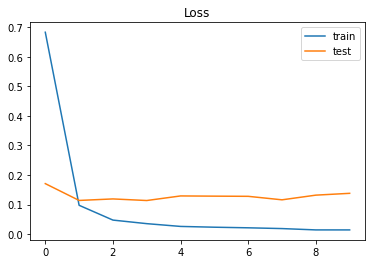

In [ ]:
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Plotting grafik akurasi hasil training

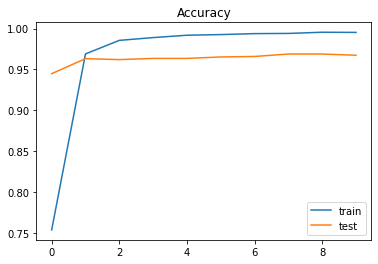

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();